In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip -u "/content/drive/My Drive/dub2_data.zip" -d "/content/drive/My Drive/dub2_projekt"

In [2]:
from scipy import ndimage
from matplotlib.pyplot import imshow
import torch

In [ ]:
#!git clone https://TOKEN@github.com/mperic7/du2_projekt duboko_projekt

Cloning into 'duboko_projekt2'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 0), reused 7 (delta 0), pack-reused 0
Receiving objects: 100% (7/7), 21.54 KiB | 918.00 KiB/s, done.


#data

In [3]:
from drive.MyDrive.duboko_projekt import faces_dataset, pickle_images2

In [4]:
#%run -i 'drive/MyDrive/duboko_projekt/pickle_images2.py'
from torchvision import transforms
from drive.MyDrive.duboko_projekt.faces_dataset import FacesDataset
dataset_x = FacesDataset("/content/drive/MyDrive/duboko_projekt/dub2_data/subset_1000/pickled/celeba_hq_256", transform=transforms.ToTensor())
dataset_y = FacesDataset("/content/drive/MyDrive/duboko_projekt/dub2_data/subset_1000/pickled/avg_blurred_images", transform=transforms.ToTensor())

In [5]:
from torch.utils.data import DataLoader
dataloader_x = DataLoader(dataset_x, shuffle=True, batch_size=128)
dataloader_y = DataLoader(dataset_y, shuffle=True, batch_size=128)

In [6]:
from drive.MyDrive.duboko_projekt.networks import Generator, Discriminator

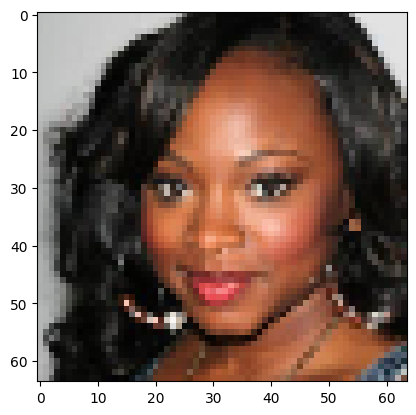

In [7]:
from PIL import Image
import numpy as np
def show_img(x):
    imshow(x.permute(1,2,0))
s = next(iter(dataloader_x))#.shape
show_img(s[0])

#training

In [14]:
gen_x = Generator(3, num_features=32)
gen_y = Generator(3, num_features=32)

disc_x = Discriminator(3)
disc_y = Discriminator(3)

In [15]:
pytorch_total_params = sum(p.numel() for p in gen_x.parameters() if p.requires_grad)
pytorch_total_params

1965059

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
gen_x = gen_x.to(device)
disc_x = disc_x.to(device)

gen_y = gen_y.to(device)
disc_y = disc_y.to(device)

tensor(2.9164, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0115, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0537, device='cuda:0', grad_fn=<MulBackward0>)


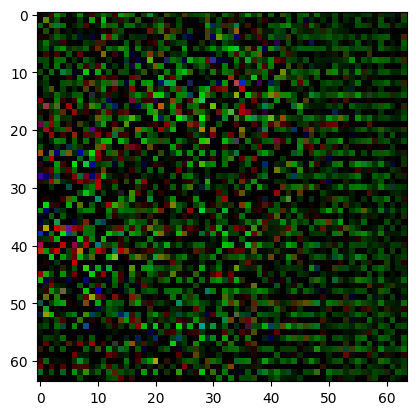

tensor(2.7696, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0081, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0419, device='cuda:0', grad_fn=<MulBackward0>)


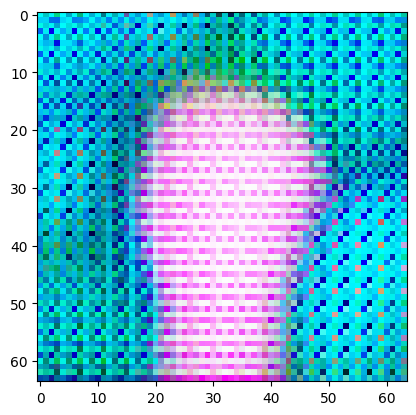

tensor(2.9009, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0068, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0348, device='cuda:0', grad_fn=<MulBackward0>)


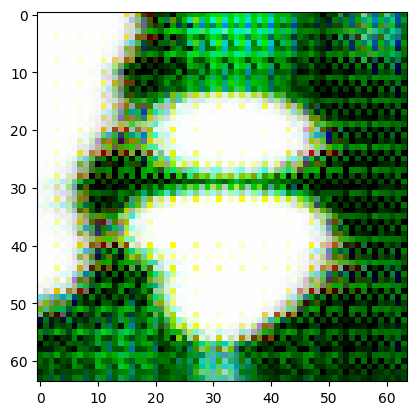

tensor(1.7200, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0084, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0309, device='cuda:0', grad_fn=<MulBackward0>)


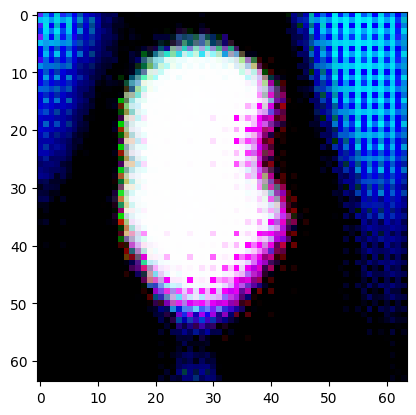

tensor(3.3874, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0053, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0268, device='cuda:0', grad_fn=<MulBackward0>)


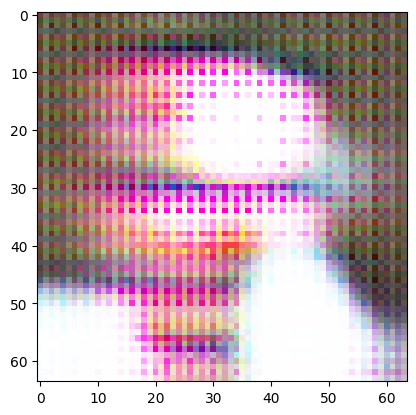

tensor(3.1703, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0046, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0243, device='cuda:0', grad_fn=<MulBackward0>)


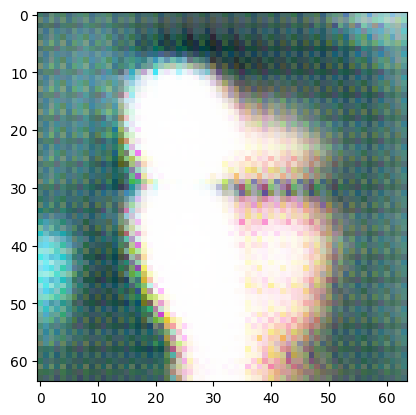

tensor(3.7013, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0057, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0348, device='cuda:0', grad_fn=<MulBackward0>)


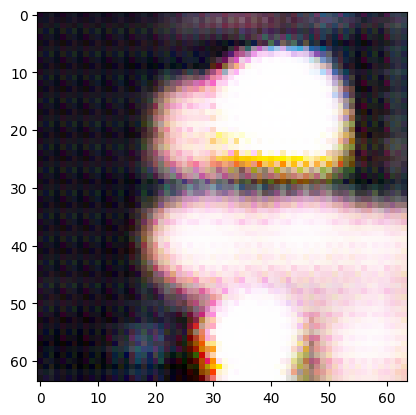

tensor(3.2226, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0040, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0228, device='cuda:0', grad_fn=<MulBackward0>)


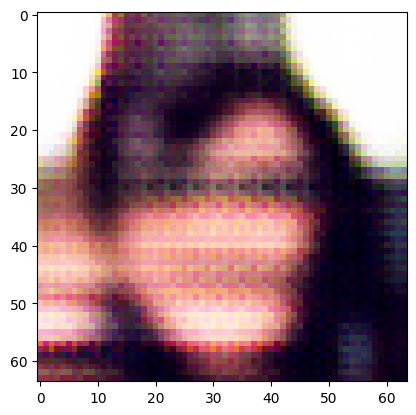

tensor(3.1843, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0040, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0229, device='cuda:0', grad_fn=<MulBackward0>)


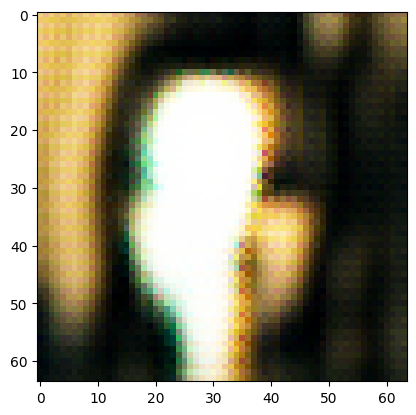

tensor(3.0772, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0051, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0303, device='cuda:0', grad_fn=<MulBackward0>)


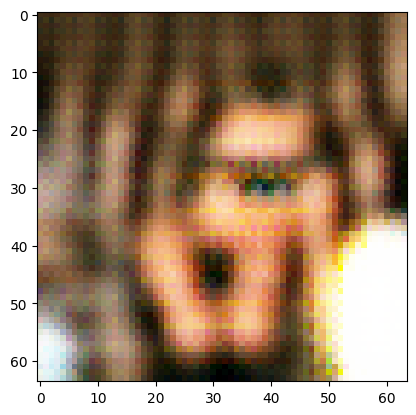

tensor(3.6148, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0042, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0226, device='cuda:0', grad_fn=<MulBackward0>)


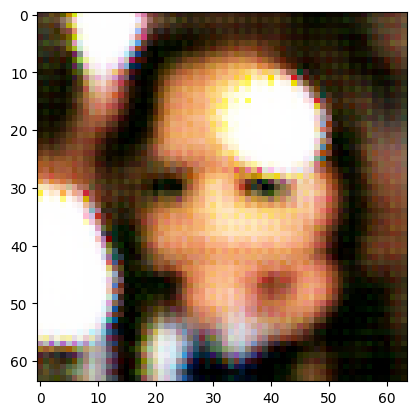

tensor(3.3778, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0039, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0223, device='cuda:0', grad_fn=<MulBackward0>)


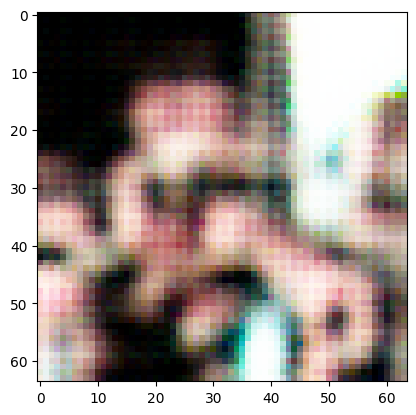

tensor(3.3804, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0034, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0189, device='cuda:0', grad_fn=<MulBackward0>)


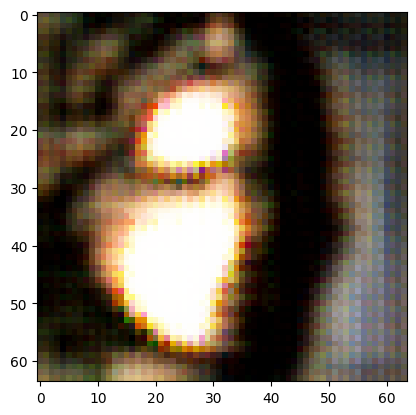

tensor(2.8403, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0041, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0236, device='cuda:0', grad_fn=<MulBackward0>)


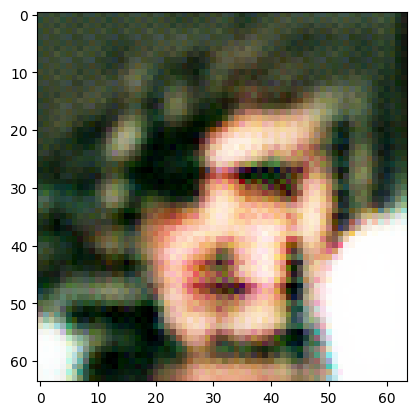

tensor(3.6752, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0044, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0272, device='cuda:0', grad_fn=<MulBackward0>)


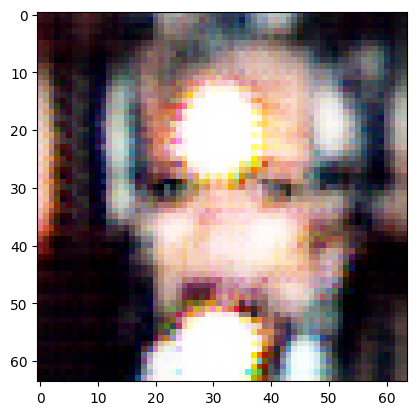

tensor(3.0224, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0038, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0221, device='cuda:0', grad_fn=<MulBackward0>)


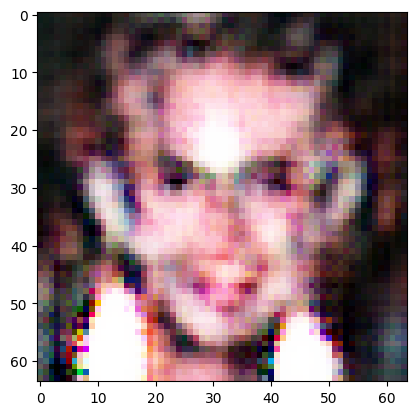

tensor(3.2223, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0046, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0261, device='cuda:0', grad_fn=<MulBackward0>)


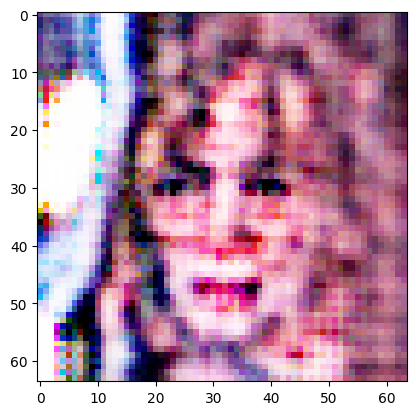

tensor(3.0223, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0036, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0210, device='cuda:0', grad_fn=<MulBackward0>)


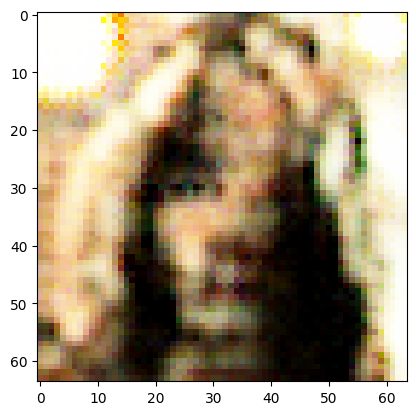

tensor(2.8583, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0037, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0235, device='cuda:0', grad_fn=<MulBackward0>)


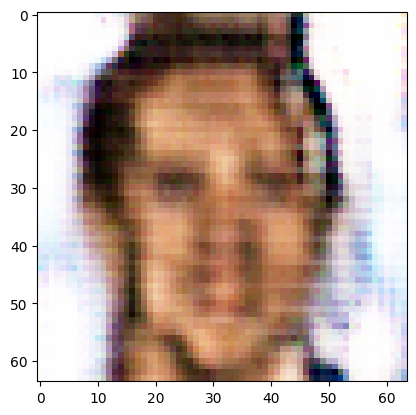

tensor(3.3179, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0038, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0223, device='cuda:0', grad_fn=<MulBackward0>)


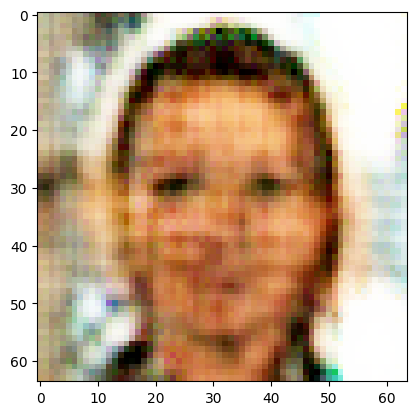

tensor(3.0897, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0033, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0185, device='cuda:0', grad_fn=<MulBackward0>)


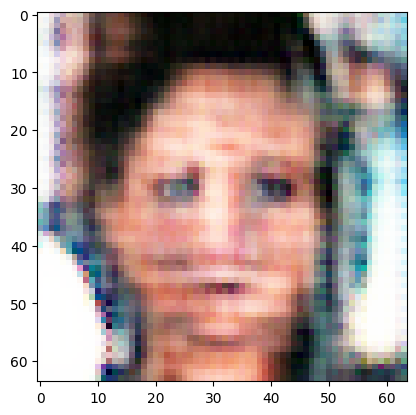

tensor(2.6766, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0033, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0186, device='cuda:0', grad_fn=<MulBackward0>)


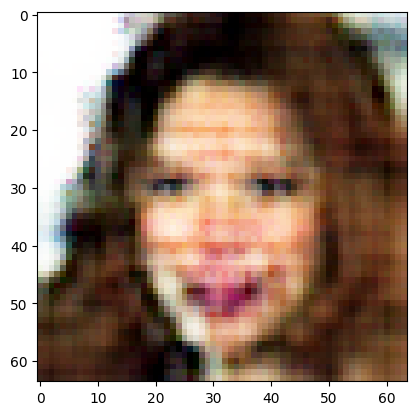

tensor(2.7610, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0037, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0222, device='cuda:0', grad_fn=<MulBackward0>)


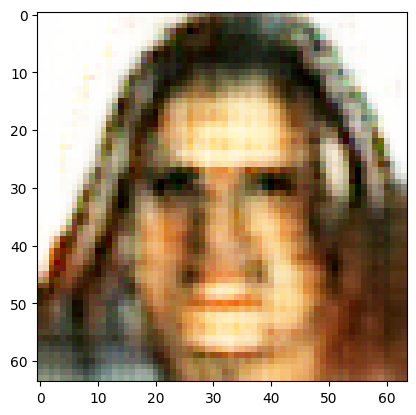

tensor(2.5984, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0036, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0214, device='cuda:0', grad_fn=<MulBackward0>)


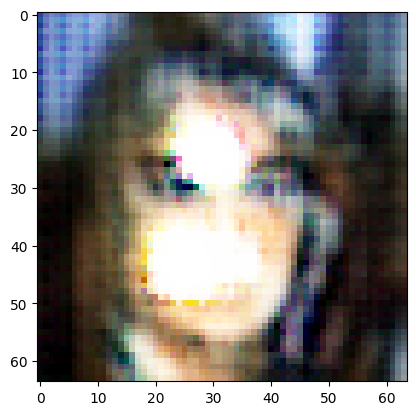

tensor(3.1396, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0034, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0201, device='cuda:0', grad_fn=<MulBackward0>)


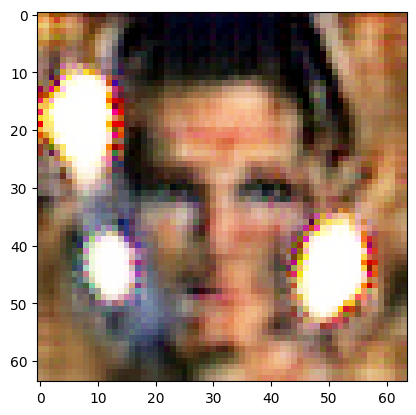

tensor(3.0698, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0032, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0159, device='cuda:0', grad_fn=<MulBackward0>)


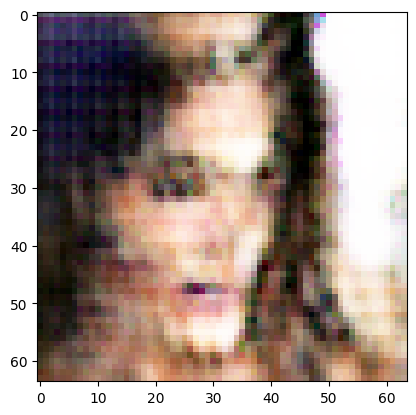

tensor(3.1897, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0032, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0168, device='cuda:0', grad_fn=<MulBackward0>)


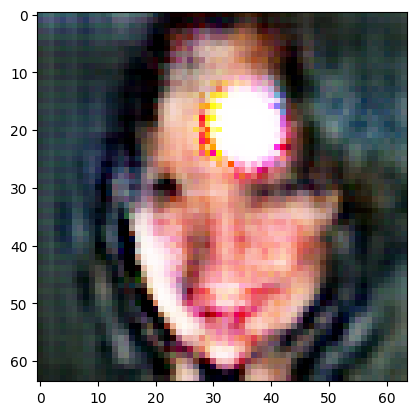

tensor(3.1330, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0035, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0198, device='cuda:0', grad_fn=<MulBackward0>)


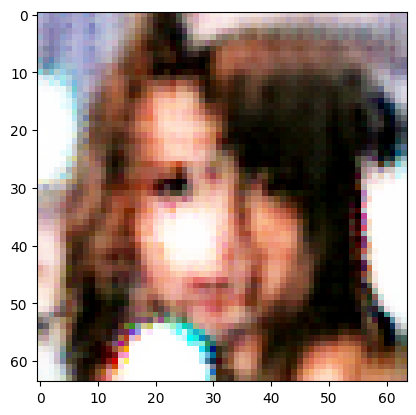

tensor(2.9978, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0029, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0150, device='cuda:0', grad_fn=<MulBackward0>)


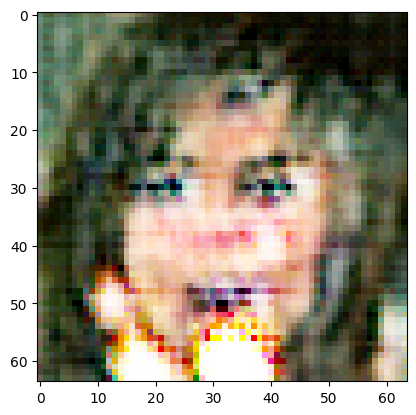

tensor(2.7557, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0036, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0212, device='cuda:0', grad_fn=<MulBackward0>)


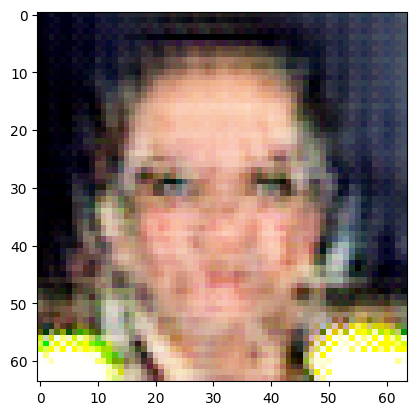

tensor(2.7611, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0030, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0165, device='cuda:0', grad_fn=<MulBackward0>)


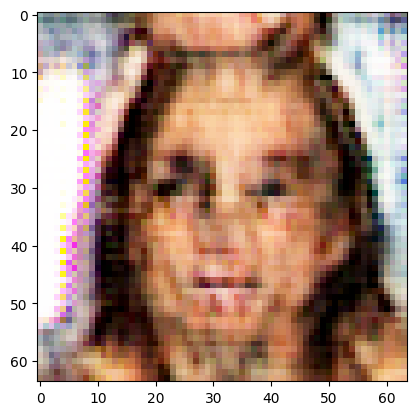

tensor(2.7330, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0032, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0157, device='cuda:0', grad_fn=<MulBackward0>)


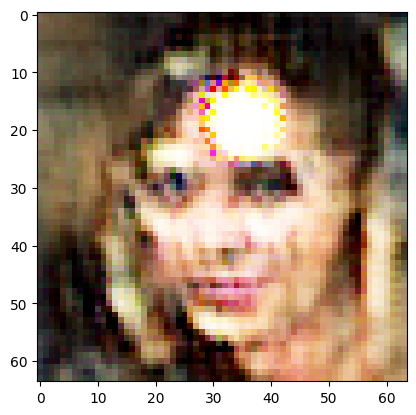

tensor(2.7532, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0029, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0149, device='cuda:0', grad_fn=<MulBackward0>)


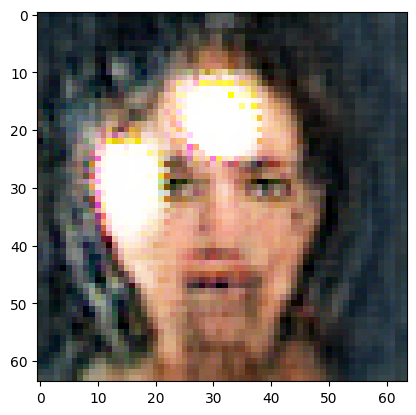

tensor(2.8489, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0035, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0188, device='cuda:0', grad_fn=<MulBackward0>)


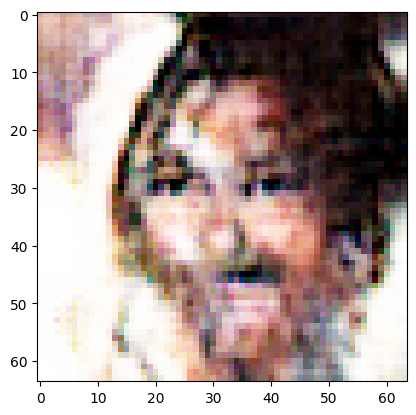

tensor(2.9288, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0036, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0205, device='cuda:0', grad_fn=<MulBackward0>)


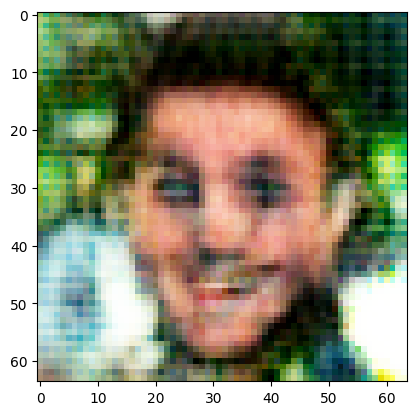

tensor(2.9647, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0032, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0181, device='cuda:0', grad_fn=<MulBackward0>)


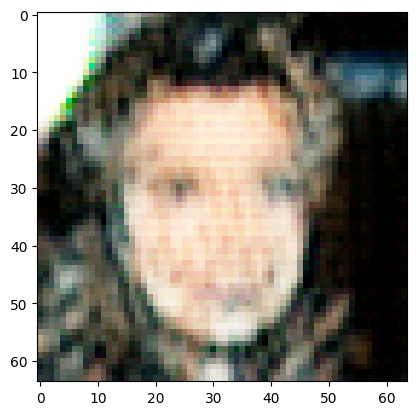

tensor(3.6888, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0035, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0198, device='cuda:0', grad_fn=<MulBackward0>)


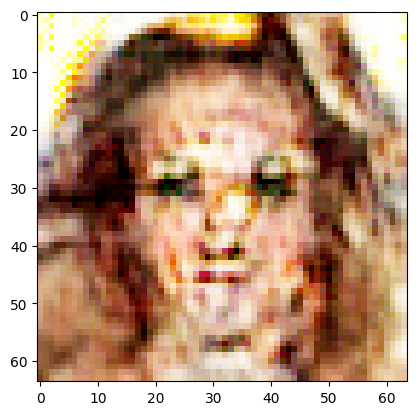

tensor(3.1657, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0033, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0180, device='cuda:0', grad_fn=<MulBackward0>)


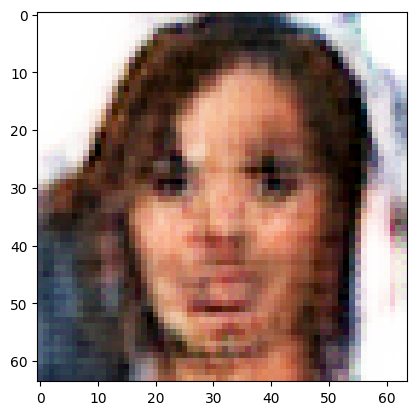

tensor(2.5886, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0033, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0210, device='cuda:0', grad_fn=<MulBackward0>)


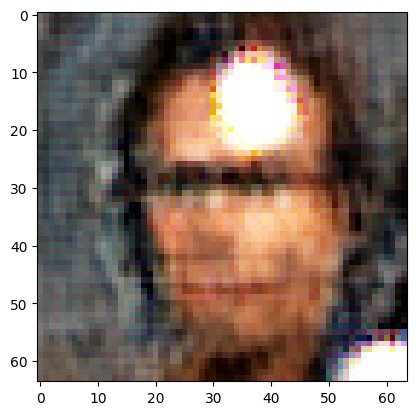

tensor(3.0892, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0031, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0164, device='cuda:0', grad_fn=<MulBackward0>)


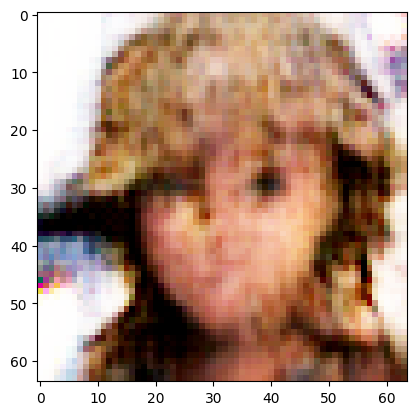

tensor(2.6649, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0031, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0171, device='cuda:0', grad_fn=<MulBackward0>)


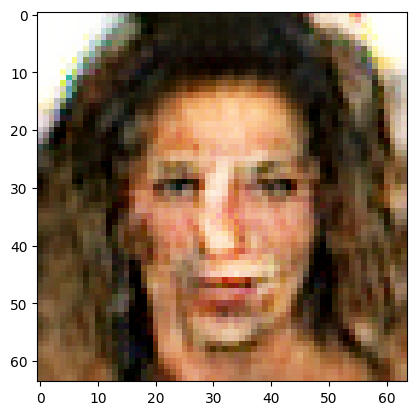

tensor(2.9410, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0036, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0235, device='cuda:0', grad_fn=<MulBackward0>)


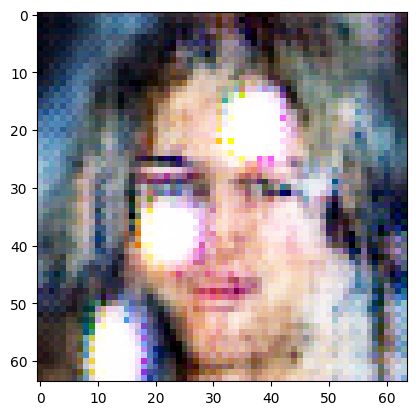

tensor(2.6118, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0029, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0158, device='cuda:0', grad_fn=<MulBackward0>)


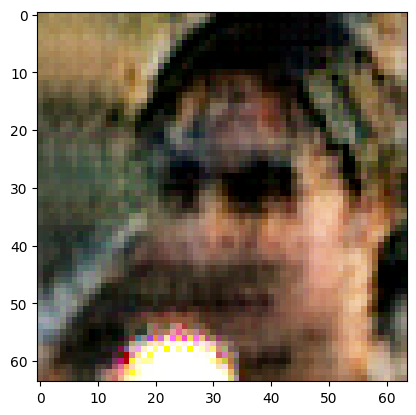

tensor(3.2009, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0029, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0155, device='cuda:0', grad_fn=<MulBackward0>)


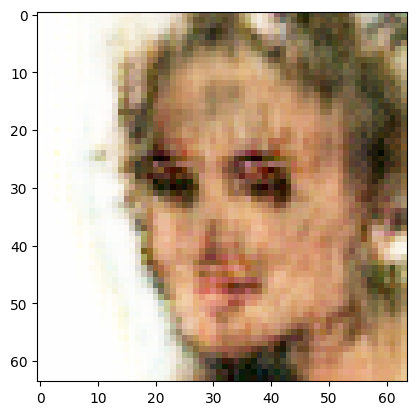

tensor(2.9009, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0031, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0178, device='cuda:0', grad_fn=<MulBackward0>)


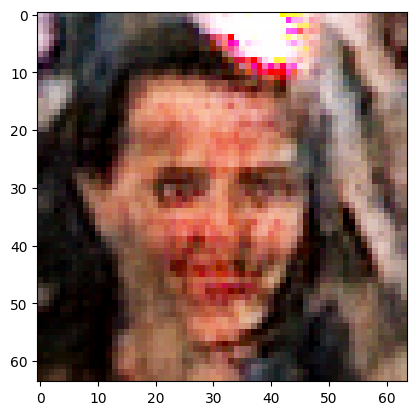

tensor(2.7662, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0032, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0167, device='cuda:0', grad_fn=<MulBackward0>)


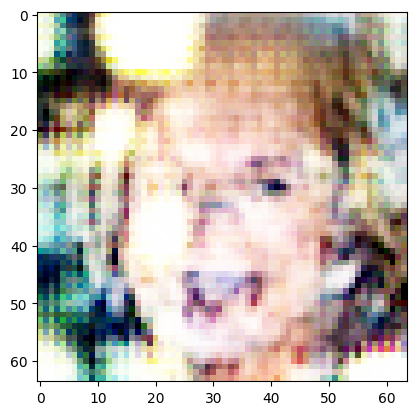

tensor(2.6531, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0028, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0142, device='cuda:0', grad_fn=<MulBackward0>)


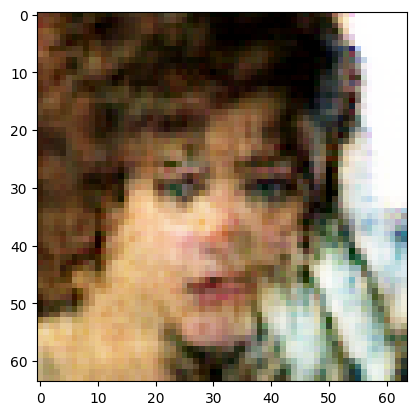

tensor(3.0052, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0029, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0159, device='cuda:0', grad_fn=<MulBackward0>)


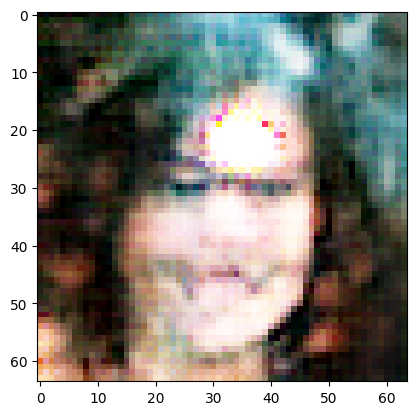

tensor(2.7059, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0032, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0181, device='cuda:0', grad_fn=<MulBackward0>)


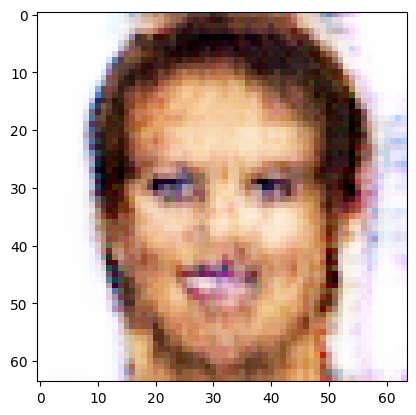

tensor(3.4931, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0031, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0161, device='cuda:0', grad_fn=<MulBackward0>)


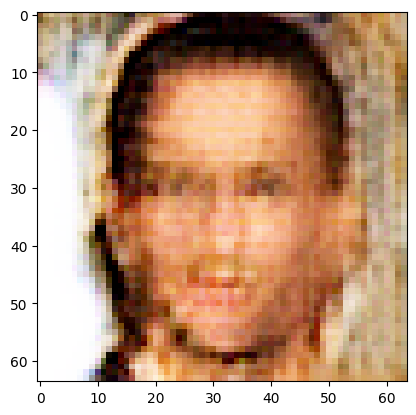

tensor(2.8787, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0035, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0177, device='cuda:0', grad_fn=<MulBackward0>)


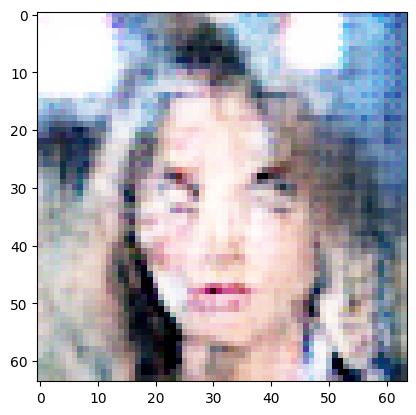

tensor(3.1452, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0031, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0171, device='cuda:0', grad_fn=<MulBackward0>)


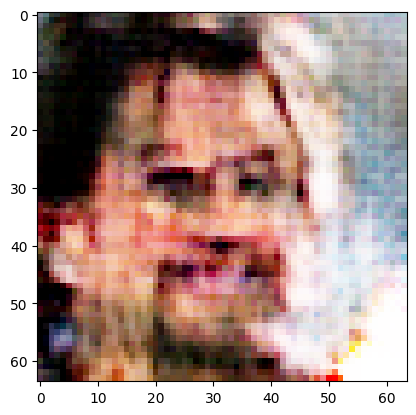

tensor(2.6244, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0033, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0191, device='cuda:0', grad_fn=<MulBackward0>)


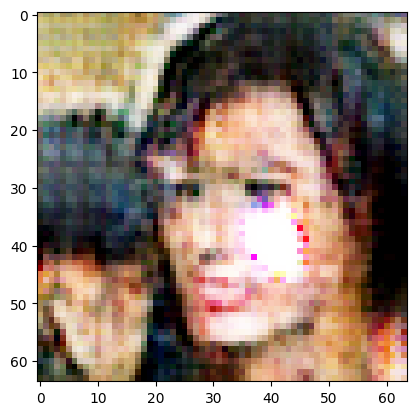

tensor(2.8096, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0029, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.0150, device='cuda:0', grad_fn=<MulBackward0>)


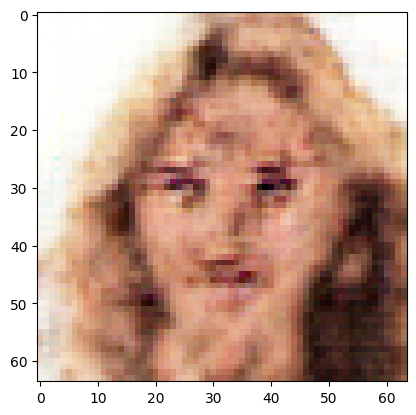

In [18]:
import torch
from matplotlib import pyplot as plt
bce_loss = torch.nn.BCELoss()
l1_loss = torch.nn.L1Loss()

lambda_identity = 0.01
lambda_cycle = 0.1
epochs = 200
opt_disc = torch.optim.Adam(
        list(disc_x.parameters()) + list(disc_y.parameters()),
        lr=0.001,
        betas=(0.5, 0.999),
    )
opt_gen = torch.optim.Adam(
        list(gen_x.parameters()) + list(gen_y.parameters()),
        lr=0.001,
        betas=(0.5, 0.999),
    )

fig = plt.figure()
step = 0
for e in range(epochs):
    for i, (x,y) in enumerate(zip(dataloader_x, dataloader_y)):

        y = y[:x.shape[0]]

        opt_disc.zero_grad()
        opt_gen.zero_grad()

        x = x.to(device)
        y = y.to(device)


        fake_x = gen_x(y)
        disc_x_real = disc_x(x)
        dics_x_fake = disc_x(fake_x)

        fake_y = gen_y(x)
        disc_y_real = disc_y(y)
        dics_y_fake = disc_y(fake_y)

        identity_x = gen_x(x)
        identity_y = gen_y(y)

        cycle_y = gen_y(fake_x)


        #identity
        identity_loss = lambda_identity * (l1_loss(identity_x,x) + l1_loss(identity_y,y))
        #cycle
        cycle_loss = lambda_cycle * l1_loss(cycle_y,y)

        if step % 6 < 3: #update discriminator
            disc_x_gan_loss = bce_loss(disc_x_real, torch.ones_like(disc_x_real)) + bce_loss(dics_x_fake, torch.zeros_like(dics_x_fake))
            disc_y_gan_loss = bce_loss(disc_y_real, torch.ones_like(disc_y_real)) + bce_loss(dics_y_fake, torch.zeros_like(dics_y_fake))
            gan_loss = disc_x_gan_loss + disc_y_gan_loss

            disc_loss = gan_loss + identity_loss + cycle_loss
            disc_loss.backward()
            opt_disc.step()

            #print(disc_loss)
        else: #update generator
            gen_x_gan_loss = bce_loss(disc_x_real, torch.zeros_like(disc_x_real)) + bce_loss(dics_x_fake, torch.ones_like(dics_x_fake))
            gen_y_gan_loss = bce_loss(disc_y_real, torch.zeros_like(disc_y_real)) + bce_loss(dics_y_fake, torch.ones_like(dics_y_fake))
            gan_loss = gen_x_gan_loss + gen_y_gan_loss
            gen_loss = gan_loss + identity_loss + cycle_loss
            gen_loss.backward()
            opt_gen.step()

            #print(gen_loss)

        if step % 30 == 0:
            print(gan_loss, identity_loss, cycle_loss)
            show_img(fake_x[0].cpu().detach())
            plt.show()
        step += 1


In [19]:
SAVE_PATH = "/content/drive/MyDrive/duboko_projekt/dub2_data/subset_1000/"
torch.save(gen_x.state_dict(), SAVE_PATH + "gen_x.pth")
torch.save(gen_y.state_dict(), SAVE_PATH + "gen_y.pth")

torch.save(disc_x.state_dict(), SAVE_PATH + "disc_x.pth")
torch.save(disc_y.state_dict(), SAVE_PATH + "disc_y.pth")
